In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import sys
import os
import torch
import numpy as np
import torch.nn as nn
from matplotlib import pyplot as plt

In [3]:
import pickle
from dotenv import load_dotenv

load_dotenv()

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "../../.."))

PRINT_EVERY = 1000

## Start: Importing local packages. As I don't know how to run it as module
## with torchrun  (e.g., python -m trainer.Coronary_ddp_trainer)

if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from src.data.IBM_data_loader import generate_fluid_testing_dataset
from src.utils.utils import lp_error
from src.utils.logger import Logging

device = "cpu"  # torch.device("cuda" if torch.cuda.is_available() else "cpu")

# file_path = "/home/vlq26735/saiful/afrah/datasets/IBM/IB_PINN3.mat"

# h=  0.498715
# k=  0.6851750000000001
# rx=  0.209685
# ry=  0.21008499999999997

In [4]:
TEST_CHECKPOINT_PATH = os.path.join(PROJECT_ROOT, "testing_checkpoints/fsi")


logger = Logging(TEST_CHECKPOINT_PATH)
model_dirname = logger.get_output_dir()

logger.print(f"Device used {device}")
logger.print(f"Result directory {model_dirname}")

INFO:src.utils.logger:Device used cpu
INFO:src.utils.logger:Result directory /home/ubuntu/afrah/code/pinn_fsi_ibm/testing_checkpoints/fsi/2024-10-18_14-07-39-042069


In [5]:
from src.data.IBM_data_loader import generate_fluid_testing_dataset

TEST_DATA_PATH = "../../../data/IB_PINN3.mat"


[time_, xfa, yfa, ufa, vfa, pfa, fxfa, fyfa] = generate_fluid_testing_dataset(
    TEST_DATA_PATH
)

In [33]:
MODEL_PATH = "/home/ubuntu/afrah/code/pinn_fsi_ibm/checkpoints/fsi/2024-10-18_14-27-37-153943/model.pth"

In [44]:
# Initialize models to None


model_fluid = None

# Load the state from the saved model
state = torch.load(MODEL_PATH)
config = state.get("config", {})
loss_history = state.get("loss_history", [])
solver = config.get("solver")

for lkey, lvalue in loss_history.items():
    logger.print(f"loss: {lkey} , final loss: {lvalue[-1]:.2e}")
# Log model summary and configuration
logger.print("_summary of the model _")
logger.print("model path:", MODEL_PATH)
logger.print("model configuration:")
for key, value in config.items():
    logger.print(f"{key} : {value}")
# Extract model configuration from state
model_activation_name = config.get("activation", "Tanh")
model_fluid_architecture = config.get("network")

# Map activation names to PyTorch activation functions

fluid_data_mean = state.get("data_mean").to("cpu")
fluid_data_std = state.get("data_std").to("cpu")


SOLVER_TO_MODULE = {
    "tanh": "src.nn.tanh",
    "xsig": "src.nn.xsigmoid",
    "bspline": "src.nn.bspline",
}

# Dynamically import the correct module and class
if solver in SOLVER_TO_MODULE:
    module = __import__(SOLVER_TO_MODULE[solver], fromlist=["PINNKAN"])
    PINNKAN = getattr(module, "PINNKAN")

    # Initialize fluid and solid models
    model_fluid = PINNKAN(model_fluid_architecture, model_activation_name).to(device)

# Plot the loss history if available

# Load the saved state dictionaries into the models
model_fluid.load_state_dict(state["model_state_dict"])

INFO:src.utils.logger:loss: left , final loss: 9.61e-03
INFO:src.utils.logger:loss: right , final loss: 1.50e-03
INFO:src.utils.logger:loss: bottom , final loss: 6.19e-04
INFO:src.utils.logger:loss: up , final loss: 4.45e-03
INFO:src.utils.logger:loss: fluid_points , final loss: 1.50e+00
INFO:src.utils.logger:loss: initial , final loss: 1.01e-02
INFO:src.utils.logger:loss: fluid , final loss: 4.02e+00
INFO:src.utils.logger:_summary of the model _
INFO:src.utils.logger:model path:
INFO:src.utils.logger:/home/ubuntu/afrah/code/pinn_fsi_ibm/checkpoints/fsi/2024-10-18_14-27-37-153943/model.pth
INFO:src.utils.logger:model configuration:
INFO:src.utils.logger:batch_size : 100
INFO:src.utils.logger:network : [3, 400, 400, 400, 400, 5]
INFO:src.utils.logger:activation : xsig
INFO:src.utils.logger:solver : xsig
INFO:src.utils.logger:weighting : Fixed
INFO:src.utils.logger:problem : fsi
INFO:src.utils.logger:total_epochs : 60000
INFO:src.utils.logger:print_every : 1000
INFO:src.utils.logger:save

<All keys matched successfully>

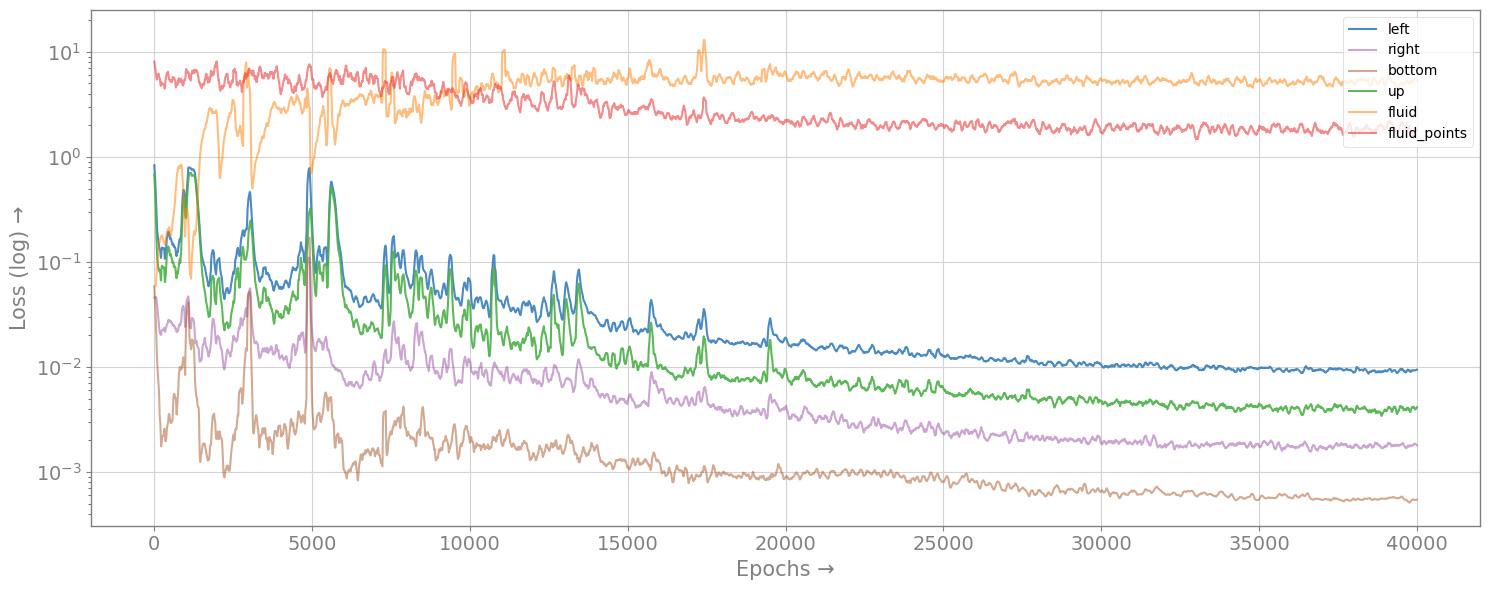

In [45]:
from src.utils.color import model_color
from src.utils.plot_loss import plot_loss_history

data_list = [
    {
        "data": loss_history["left"],
        "color": model_color["bspline"],
        "name": "left",
        "alpha": 0.9,
        "window": 100,
        "show_avg": False,
        "show_lower": False,
    },
    {
        "data": loss_history["right"],
        "color": model_color["tanh"],
        "name": "right",
        "alpha": 0.5,
        "window": 100,
        "show_avg": False,
        "show_lower": False,
    },
    {
        "data": loss_history["bottom"],
        "color": model_color["grbf"],
        "name": "bottom",
        "alpha": 0.5,
        "window": 100,
        "show_avg": False,
        "show_lower": False,
    },
    {
        "data": loss_history["up"],
        "color": model_color["fourier"],
        "name": "up",
        "alpha": 0.9,
        "window": 100,
        "show_avg": False,
        "show_lower": False,
    },
    {
        "data": loss_history["fluid"],
        "color": model_color["param_tanh"],
        "name": "fluid",
        "alpha": 0.5,
        "window": 100,
        "show_avg": False,
        "show_lower": False,
    },
    {
        "data": loss_history["fluid_points"],
        "color": model_color["chebyshev"],
        "name": "fluid_points",
        "alpha": 0.5,
        "window": 100,
        "show_avg": False,
        "show_lower": False,
    },
]


plot_loss_history(
    data_list,
    os.path.join(logger.get_output_dir(), "loss_history_fsi.png"),
    y_max=25,
)

In [46]:
test_torch_data = torch.tensor(
    np.concatenate([time_, xfa, yfa, ufa, vfa, pfa], axis=1), dtype=torch.float32
).to("cpu")
with torch.no_grad():
    predictions1 = model_fluid.forward(
        test_torch_data[:, :3], fluid_data_mean[:3], fluid_data_std[:3]
    )

if predictions1.is_cuda:
    predictions1 = predictions1.cpu()
u_pred = predictions1[:, 0:1].numpy()
v_pred = predictions1[:, 1:2].numpy()
p_pred = predictions1[:, 2:3].numpy()
fx_pred = predictions1[:, 3:4].numpy()
fy_pred = predictions1[:, 4:5].numpy()

In [47]:
#

text = "RelL2_"
# logger.print("\n Relative L2 ERROR:")
u_error2 = lp_error(u_pred, ufa, (text + "U%"), logger, 2)
v_error2 = lp_error(v_pred, vfa, (text + "V%"), logger, 2)
p_error2 = lp_error(p_pred, pfa, (text + "P%"), logger, 2)
fx_error2 = lp_error(fx_pred, fxfa, (text + "Fx%"), logger, 2)
fy_error2 = lp_error(fy_pred, fyfa, (text + "Fy%"), logger, 2)

# # logger.print("\n Relative l1 error")
# text = "RelL1_"
# u_error1 = lp_error(    u_pred, ufa, (text + "U%"), logger, 1)
# v_error1 = lp_error(    v_pred, vfa, (text + "V%"), logger, 1)
# p_error1 = lp_error(    p_pred, pfa, (text + "P%"), logger, 1)
# fx_error1 = lp_error(    fx_pred, fxfa, (text + "Fx%"), logger, 1)
# fy_error1 = lp_error(    fy_pred, fyfa, (text + "Fy%"), logger, 1)

mean_velocity = (u_error2 + v_error2) / 2
print(f"mean velocity: {mean_velocity:0.3e}")

mean_force = (fx_error2 + fy_error2) / 2
print(f"mean_force: {mean_force:0.3e}")

print(f"p_error2: {p_error2:0.3e}")

INFO:src.utils.logger:RelL2_U%  : 29.57 


INFO:src.utils.logger:RelL2_V%  : 80.75 
INFO:src.utils.logger:RelL2_P%  : 64.68 
INFO:src.utils.logger:RelL2_Fx%  : 72.46 
INFO:src.utils.logger:RelL2_Fy%  : 70.73 


mean velocity: 5.516e+01
mean_force: 7.159e+01
p_error2: 6.468e+01


In [ ]:
INFO:src.utils.logger:RelL2_U%  : 29.57 
INFO:src.utils.logger:RelL2_V%  : 80.75 
INFO:src.utils.logger:RelL2_P%  : 64.68 
INFO:src.utils.logger:RelL2_Fx%  : 72.46 
INFO:src.utils.logger:RelL2_Fy%  : 70.73 
mean velocity: 5.516e+01
mean_force: 7.159e+01
p_error2: 6.468e+01


In [48]:
from src.utils.plotting_regular_2D import plot_time_profile_regular_data_IBM
from src.utils.plotting_regular_2D import draw_contourf_regular_2D

tstep = 101
xstep = 102
ystep = 102
part = "Fluid"
N_data = xstep * ystep

steps = [tstep, xstep, ystep]
txy = [xfa, yfa, time_]

plot_time_profile_regular_data_IBM(
    logger.get_output_dir(), steps, txy, ufa, u_pred, "$u$"
)
plot_time_profile_regular_data_IBM(
    logger.get_output_dir(), steps, txy, vfa, v_pred, "$v$"
)
plot_time_profile_regular_data_IBM(
    logger.get_output_dir(), steps, txy, pfa, p_pred, "$p$"
)
plot_time_profile_regular_data_IBM(
    logger.get_output_dir(), steps, txy, fxfa, fx_pred, "_$Fx$_"
)
plot_time_profile_regular_data_IBM(
    logger.get_output_dir(), steps, txy, fyfa, fy_pred, "_$Fy$_"
)


tstep = 101
xstep = 102
ystep = 102

#  t = tf.reshape(tstep,N_data)[:,0].T
tf100 = time_.reshape(tstep, xstep, ystep)[:, 0, 0]
fluid_x = xfa.reshape(tstep, xstep, ystep)[0, :, 0]  # .reshape(100,100)[0,:]
fluid_y = yfa.reshape(tstep, xstep, ystep)[0, 0, :]  # .reshape(100,100)[:,0]

ufa100 = ufa.reshape(tstep, xstep, ystep).transpose((0, 2, 1))  # .reshape(100,100)[0,:]
vfa100 = vfa.reshape(tstep, xstep, ystep).transpose((0, 2, 1))  # .reshape(100,100)[0,:]
pfa100 = pfa.reshape(tstep, xstep, ystep).transpose(
    (0, 2, 1)
)  # [1,:].reshape(100,100)[0,:]
fxfa100 = fxfa.reshape(tstep, xstep, ystep).transpose(
    (0, 2, 1)
)  # [1,:].reshape(100,100)[0,:]
fyfa100 = fyfa.reshape(tstep, xstep, ystep).transpose(
    (0, 2, 1)
)  # [1,:].reshape(100,100)[0,:]

u_pred100 = u_pred.reshape(tstep, xstep, ystep).transpose(
    (0, 2, 1)
)  # .reshape(100,100)[0,:]
v_pred100 = v_pred.reshape(tstep, xstep, ystep).transpose(
    (0, 2, 1)
)  # .reshape(100,100)[0,:]
p_pred100 = p_pred.reshape(tstep, xstep, ystep).transpose(
    (0, 2, 1)
)  # [1,:].reshape(100,100)[0,:]
fx_pred100 = fx_pred.reshape(tstep, xstep, ystep).transpose(
    (0, 2, 1)
)  # [1,:].reshape(100,100)[0,:]
fy_pred100 = fy_pred.reshape(tstep, xstep, ystep).transpose(
    (0, 2, 1)
)  # [1,:].reshape(100,100)[0,:]

error_u = np.abs(ufa100 - u_pred100)  # (u - u_pred) / u # np.abs(u - u_pred)
error_v = np.abs(vfa100 - v_pred100)  # (v - v_pred) / v # np.abs(v - v_pred)
error_p = np.abs(pfa100 - p_pred100)  # (p - p_pred) / p # np.abs(p - p_pred)
error_fx = np.abs(fxfa100 - fx_pred100)  # (p - p_pred) / p # np.abs(p - p_pred)
error_fy = np.abs(fyfa100 - fy_pred100)  # (p - p_pred) / p # np.abs(p - p_pred)

time_values = [0, 50, 99]
fluid_data = [
    u_pred100,
    v_pred100,
    p_pred100,
    fx_pred100,
    fy_pred100,
    ufa100,
    vfa100,
    pfa100,
    fxfa100,
    fyfa100,
    error_u,
    error_v,
    error_p,
    error_fx,
    error_fy,
]

nrows_ncols = (3, 5)
time_values = [99, 50, 0]
titles = [
    "u_pinn",
    "v_pinn",
    "p_pinn",
    "fx_pinn",
    "fy_pinn",
    "u_cfd",
    "v_cfd",
    "p_cfd",
    "fx_cfd",
    "fy_cfd",
    "error_u",
    "error_v",
    "error_p",
    "error_fx",
    "error_fy",
]

draw_contourf_regular_2D(
    tf100,
    fluid_x,
    fluid_y,
    fluid_data,
    titles,
    nrows_ncols,
    time_values,
    1.0,
    1.0,
    model_dirname,
    15,
    12,
    5,
    fontsize=9.5,
    labelsize=9.5,
    axes_pad=1.0,
)